# <font color=#f4665a>  ICA analysis </font>

### Project: BMPD HC
____________________________________________________

**Description:** This notebook provides code for BOLD signal fMRI resting-state processing for the Biomarker for Parkinson's Disease (BMPD)data. 
We will used ICA analysis:
CanICA is an ICA package for group-level analysis of fMRI data.  
It brings a well-controlled group model, as well as a thresholding algorithm controlling for specificity and sensitivity with an explicit model of the signal.  
The reference papers are: G. Varoquaux et al. "A group model for stable multi-subject ICA on fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299
G. Varoquaux et al. "ICA-based sparse features recovery from fMRI datasets", IEEE ISBI 2010, p. 1177


**Toolbox required:** SpinalCordToolbox, FSL, nilearn toolbox, nipype, matlab

**Inputs**:  
This notebook required this the following prepross anatomical,fmri images 

**Ouputs**:
See the output description at each step of the Notebook.

____________________________________________________


## <font color=#00988c> Imports </font>

In [13]:
import sys
import json
# Spinal cord Toolbox_________________________________________
### Cerebro:
sys.path.append("/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.0.0")
sys.path.append("/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.0.0/scripts") #sys.path.insert(0, "/cerebro/cerebro1/dataset/bmpd/derivatives/sc_preproc/code/sct/spinalcordtoolbox")
sys.path.append("/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/code/") #sys.path.insert(0, "/cerebro/cerebro1/dataset/bmpd/derivatives/sc_preproc/code/sct/spinalcordtoolbox")

from spinalcordtoolbox.utils.sys import run_proc

from canICA_analyses import ICA
%matplotlib inline
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <font color=#00988c>  Run the ICA analysis </font>

In [2]:
# Load the dataset config
#config_spine_only_CL.json #../config/config_brsc_CL.json
with open('../config/config_spine_only_CL.json') as config_file:
    config = json.load(config_file)
dataset="mtl" 
structures=["spinalcord"] # ["spinalcord"] or ["brain","spinalcord"] . double check the script for brainsc

In [3]:
import glob
files_func={};func_allsbj={}
for structure in structures:
    if len(structures) == 1:
        ana=structure
    else:
        ana= "brain_spinalcord"
    files_func[structure]=[];func_allsbj[structure]=[]
    for sbj_nb in range(len(config["list_subjects"][dataset])):
        subject_name=config["list_subjects"][dataset][sbj_nb]
        files_func[structure].append(glob.glob(config["data"][dataset]["inputs_ica"]["dir"]+ '/sub-' + subject_name + '/'  + structure + '/*' + config["data"][dataset]["inputs_ica"][structure]["tag_filename_" + ana] + '*')[0])
        

In [5]:
for k in [8]:#config["ica_ana"]["k_range"]["spinalcord"]:
    config["ica_ana"]["n_comp"]=k # usefull if you want to test only on k
    print(config["ica_ana"]["n_comp"])
    icas = ICA(files_func[structure],[''],structures,dataset,config) # "brain_spinalcord" or "brain" or "spinalcord"
    #icas = ICA(files_func[structures[0]],files_func[structures[1]],structures,dataset,config) # "brain_spinalcord" or "brain" or "spinalcord"
    if k==4:
        all_data=icas.get_data(run='extract',t_r=config["acq_params"][dataset]["TR"],n_jobs=1) # load or extract
    all_data=icas.get_data(run='load',t_r=config["acq_params"][dataset]["TR"],n_jobs=8) # load or extract
        
    

8
Analyse will be run on spinalcord structure
Mask: /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//templates/PAM50/template/PAM50_cord_C1toC8.nii.gz


## Individual data

all data shape:(265, 65813)


Text(0.5, 1.0, 'Time series for one voxel')

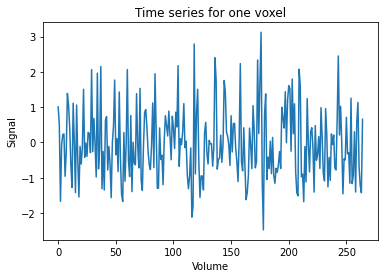

In [12]:
print("all data shape:" + str(all_data[0].shape))
plt.plot(all_data[0][:,100]) # first sbj 100th voxel 
plt.xlabel('Volume')
plt.ylabel('Signal')
plt.title('Time series for one voxel')

## Individual PCA: 
### The activity recorded on each subject id described by a set of subject-specific spatial patterns P
We separate observation noise from subject-specific patterns through principal component analysis (PCA).   
The principal components explaining most of the variance for a given subject's data set form the patterns of interest, while the tail of the spectrum is considered as observation noise.  
Specifically, for each subject, we use a singular value decomposition (SVD) of the individual data matrix
> input: matrix of data with the shape: n_voxels x n_volumes (masker.trasnform(img).T)  
> Output: concatenated all subjects components with the shape : (n_subj X n_comp) , n_voxels

this step reduce the data in time

reducedata_all shape (420, 65813)
(n_comp*n_sbj,n_voxels)


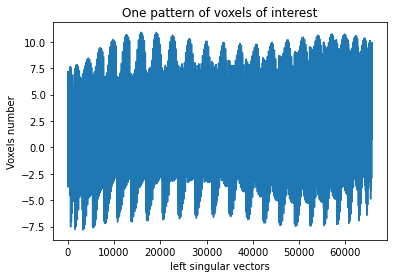

In [108]:
#reducedata_all=icas.indiv_PCA(all_data,save_indiv_img=False) # that step is not implanted to save individual maps for brain + sc yet
from scipy import linalg
from sklearn.utils.extmath import svd_flip
import numpy as np
reducedata_all=[]
n_comp=20 # number of individual component
for sbj_nb in range(0,len(all_data)): # the exemple is provided for 2 sbj to be faster
    U, S, V = linalg.svd(all_data[0].T, full_matrices=False) # transpose the matrice of data in voxels x volumes
    # U: U is the left singular vectors, S (sigma) is the diagonal/eigenvalues, V:  is the right singular vectors,
    U, V = svd_flip(U, V) # # flip eigenvectors' sign to enforce deterministic output
    U = U[:, :n_comp].copy(); #The 1D projection axis with the maximum variance preserved
    S = S[:n_comp]; #The maximum variance preserving axis perpendicular to previous. 
    V = V[:n_comp].copy() #he third axis is automatically the one which is perpendicular to first two.
    U = U.T.copy()
    U = U * S[:, np.newaxis]
    if sbj_nb==0:
        reducedata_all = U
    else: 
#>>> Concatenation of indvidual Patterns of interests        
        reducedata_all=np.concatenate([reducedata_all, U]) # concatenation of individual components, sbj1PC1, sbj1PC2 ... sbjnPC1,sbjnPC2.. (n_comp*n_sbj,n_voxels)

        
plt.plot(U[1,:]) # first sbj 100th voxel
plt.ylabel('Voxels number')
plt.xlabel('left singular vectors')
plt.title('One pattern of voxels of interest')
print("reducedata_all shape " + str(reducedata_all.shape))
print("(n_comp*n_sbj,n_voxels)" )

## Canonical correlation analysis
CCA is used identify a stable-component subspace across subjects

In [109]:
#components=icas.get_CCA(reducedata_all)
from sklearn.utils.extmath import randomized_svd
n_comp_cca=k
S = np.sqrt(np.sum(reducedata_all** 2, axis=1)) #Calculate the root sum square = canonical root or variate. for each individual the value will decrease from the first to the last component
S[S == 0] = 1 # if one value is equale to 0 change it by 1
reducedata_all /= S[:, np.newaxis] # divide data by canonical root (proportion of variance)
components_, variance_, _=randomized_svd(reducedata_all.T, n_components=n_comp_cca,transpose=True,n_iter=3,random_state=None) #SVD is equivalent to standard CCA
reducedata_all *= S[:, np.newaxis] # # Untransform the original reduced data

## FastICA
Components extracted from CCA represent a mixture of various processes and are difficult to
interpret for lack of distinguishable shape standing out. 

In [111]:
from sklearn.utils import check_random_state
from sklearn.decomposition import fastica
from operator import itemgetter
iter=50
random_state=None
ratio=1.#float(15)
random_state = check_random_state(random_state)
seeds = random_state.randint(np.iinfo(np.int32).max, size=iter)
components_.astype(np.float64) # to avoid NaN and inf values
results = (fastica(components_, whiten=True, fun='cube',random_state=seed)
           for seed in seeds)
ica_maps_gen_ = (result[2] for result in results)
ica_maps_and_sparsities = ((ica_map,
                                    np.sum(np.abs(ica_map), axis=1).max())
                                   for ica_map in ica_maps_gen_)
ica_maps, _ = min(ica_maps_and_sparsities, key=itemgetter(-1))
components_= ica_maps.astype(components_.dtype)

/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/sklearn/decomposition/_fastica.py:120:

## Dual regression
The dual-regression approach is used to identify, within each subject's fMRI data set, subject-specific temporal dynamics and associated spatial maps.
1) Temporal regression: This involves (i) using the full set of group-ICA spatial maps in a linear model fit (spatial regression) against the separate fMRI data sets, resulting in matrices describing temporal dynamics for each component and subject, and (ii) using these time-course matrices in a linear model fit (temporal regression) against the associated fMRI data set to estimate subject-specific spatial maps

In [112]:
from sklearn.linear_model import LinearRegression
all_data # subject data:
input_rest = all_data[0]
model = LinearRegression()
model.fit(components_, all_data[1].T)
temporal_coefficients = model.coef_  


In [99]:
from sklearn.preprocessing import StandardScaler
S = StandardScaler(with_mean=False, with_std=True)
Z = StandardScaler(with_mean=True, with_std=True)
temporal_coefficients = S.fit_transform(temporal_coefficients)

model = LinearRegression()
model.fit(temporal_coefficients, all_data[0])
spatial_coefficients = model.coef_
spatial_coefficients = Z.fit_transform(spatial_coefficients)

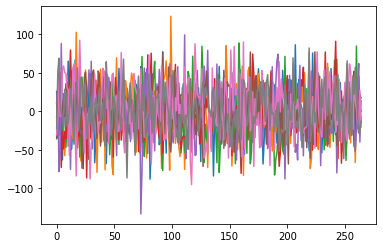

In [117]:
plt.plot(temporal_coefficients[:,:])

In [123]:
if components_.shape[0] !=  all_data[1].shape[0]:
    raise Exception("Shape should be the number of voxels for both component matrix and indiviual data")

Exception: Shape 0 should be the number of voxels for both component matrix and indiviual data

In [125]:
temporal_coefficients.shape

(265, 8)